## Step1. Map classical inputs to a quantum problem
ref: https://learning.quantum.ibm.com/tutorial/quantum-approximate-optimization-algorithm

In [1]:
import numpy as np

from utils import make_tsp_qp, randomize_cities, brute_force_tsp, draw_tour, reorder, QISKIT_TOKEN
from qiskit_optimization.converters import QuadraticProgramToQubo

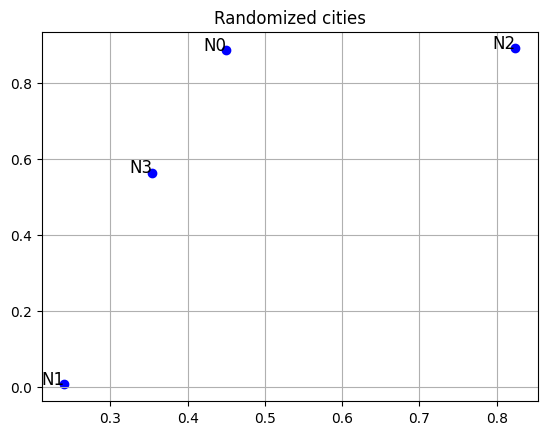

[[ 0  9  3  3]
 [ 9  0 10  5]
 [ 3 10  0  5]
 [ 3  5  5  0]]


In [2]:
# Create a random TSP problem
weights = randomize_cities(4)

# making quadratic program from TSP weights
quadratic_program = make_tsp_qp(weights)
# conveerts the quadratic program to QUBO, with a penalty of 10 (constant to scale the constraints)
qp2qubo = QuadraticProgramToQubo(penalty=10)
qubo = qp2qubo.convert(quadratic_program)
# converts the QUBO to an Ising Hamiltonian
qubitOp, offset = qubo.to_ising()

print(weights)

## Step1.2. Hamiltonian to Quantum Circuit

In [3]:
from qiskit.circuit.library import QAOAAnsatz

print(qubitOp.num_qubits)

circuit = QAOAAnsatz(cost_operator=qubitOp, reps=2)
circuit.measure_all()

# circuit.draw('mpl')
parameters = circuit.parameters
print(parameters)

16
ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(β[1]), ParameterVectorElement(γ[0]), ParameterVectorElement(γ[1])])


## Step2. Optimize circuits for quantum computer

In [4]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager


service = QiskitRuntimeService(channel='ibm_quantum', token=QISKIT_TOKEN)
backend = service.least_busy(min_num_qubits=127)
print(backend)

# Create pass manager for transpilation
pm = generate_preset_pass_manager(optimization_level=3,
                                    backend=backend)

candidate_circuit = pm.run(circuit)
# candidate_circuit.draw('mpl', fold=False, idle_wires=False)

<IBMBackend('ibm_brisbane')>


## Step3. Executing with qiskit primitives

### Define initial parameters

In [5]:
initial_gamma = np.pi
initial_beta = np.pi/2
init_params = [initial_gamma, initial_beta, initial_gamma, initial_beta]

### Define backend and execution primitive

In [6]:
objective_func_vals = [] # Global variable

def cost_func_estimator(params, ansatz, hamiltonian, estimator):

    # transform the observable defined on virtual qubits to
    # an observable defined on all physical qubits
    isa_hamiltonian = hamiltonian.apply_layout(ansatz.layout)

    pub = (ansatz, isa_hamiltonian, params)
    job = estimator.run([pub])

    results = job.result()[0]
    cost = results.data.evs

    objective_func_vals.append(cost)


    return cost

In [7]:
from qiskit_ibm_runtime import Session, EstimatorV2 as Estimator
from scipy.optimize import minimize


with Session(backend=backend) as session:
    # If using qiskit-ibm-runtime<0.24.0, change `mode=` to `session=`
    estimator = Estimator(mode=session)
    estimator.options.default_shots = 1000

    # Set simple error suppression/mitigation options
    estimator.options.dynamical_decoupling.enable = True
    estimator.options.dynamical_decoupling.sequence_type = "XY4"
    estimator.options.twirling.enable_gates = True
    estimator.options.twirling.num_randomizations = "auto"

    result = minimize(
        cost_func_estimator,
        init_params,
        args=(candidate_circuit, qubitOp, estimator),
        method="COBYLA",
        tol=1e-2,
    )
    print(result)

IBMRuntimeError: 'Failed to run program: \'400 Client Error: Bad Request for url: https://api.quantum.ibm.com/runtime/jobs. {"errors":[{"code":1217,"message":"Session has been closed.","solution":"Reduce time between submitting subsequent jobs in a session.","more_info":"https://docs.quantum-computing.ibm.com/errors"}]}\''

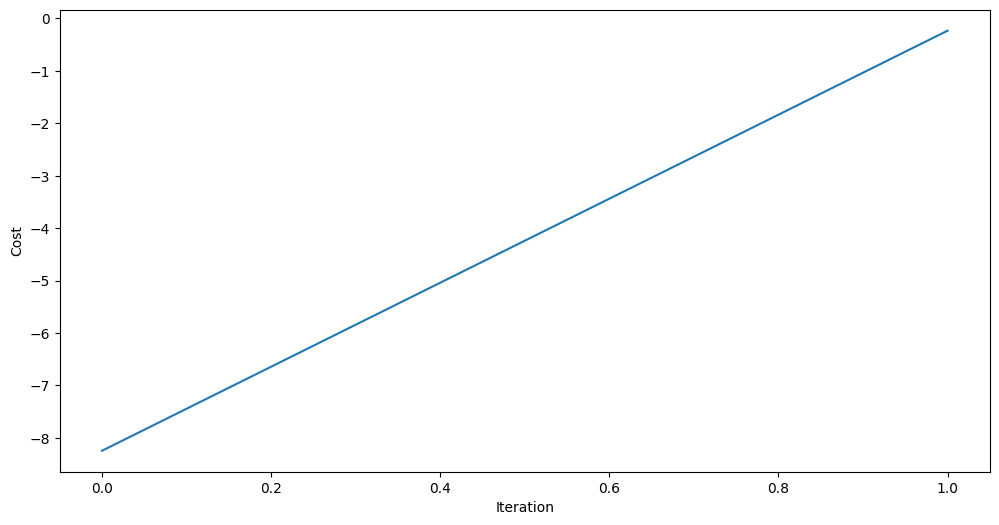

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(objective_func_vals)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

In [12]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token=QISKIT_TOKEN
)
# job = service.job('cwewzed9r49g0085qrr0')
job_result = job.result()

for idx, pub_result in enumerate(job_result):
    print(f"Expectation values for pub {idx}: {pub_result.data.evs}")

Expectation values for pub 0: -8.244909564211357


In [13]:
optimized_circuit = candidate_circuit.assign_parameters(result.x)
optimized_circuit.draw('mpl', fold=False, idle_wires=False)

AttributeError: 'PrimitiveResult' object has no attribute 'x'

In [ ]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

# If using qiskit-ibm-runtime<0.24.0, change `mode=` to `backend=`
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10000

# Set simple error suppression/mitigation options
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XY4"
sampler.options.twirling.enable_gates = True
sampler.options.twirling.num_randomizations = "auto"

pub= (optimized_circuit, )
job = sampler.run([pub], shots=int(1e4))
counts_int = job.result()[0].data.meas.get_int_counts()
counts_bin = job.result()[0].data.meas.get_counts()
shots = sum(counts_int.values())
final_distribution_int = {key: val/shots for key, val in counts_int.items()}
final_distribution_bin = {key: val/shots for key, val in counts_bin.items()}
print(final_distribution_int)

## Step4. Post-processing, return result in classical format

In [ ]:
# auxiliary functions to sample most likely bitstring

keys = list(final_distribution_int.keys())
values = list(final_distribution_int.values())
most_likely = keys[np.argmax(np.abs(values))]


print("Result bitstring:", most_likely)